In [1]:
%load_ext autoreload
%autoreload 2

In [13]:
%matplotlib inline  

from collections import OrderedDict

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.externals import joblib

from utils_evaluation import *
from utils_plotting import plot_feature_ranking

In [3]:
sns.set(style='ticks')
sns.set_palette('cubehelix')

# KiDS (mags + colors) vs. colors

In [13]:
preds_1 = pd.read_csv('experiments/KiDS_DR3_x_SDSS_DR14_cleaned_rcut__2018-03-05_14:13:44.csv')
preds_2 = pd.read_csv('experiments/KiDS_DR3_x_SDSS_DR14_cleaned_colors_cut__2018-03-05_13:59:06.csv')

In [14]:
id_intersection = np.intersect1d(preds_1['ID'], preds_2['ID'])
set_intersection = preds_1.loc[preds_1['ID'].isin(id_intersection)]
id_intersection.shape

(23188,)

In [15]:
print(np.unique(preds_1['CLASS'], return_counts=True))
print(np.unique(preds_2['CLASS'], return_counts=True))
print(np.unique(set_intersection['CLASS'], return_counts=True))

(array(['GALAXY', 'QSO', 'STAR'], dtype=object), array([12089,  4352,  7329]))
(array(['GALAXY', 'QSO', 'STAR'], dtype=object), array([12090,  4098,  7231]))
(array(['GALAXY', 'QSO', 'STAR'], dtype=object), array([12071,  3911,  7206]))


/home/snakoneczny/tools/python3/lib/python3.5/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


Multiclass classification results:
Accuracy = 0.9417
F1 per class = [0.9696 0.8699 0.9335]


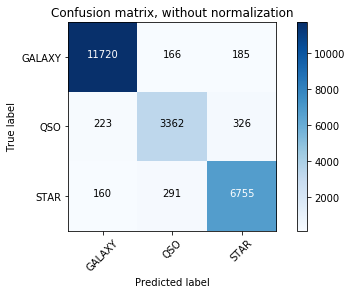

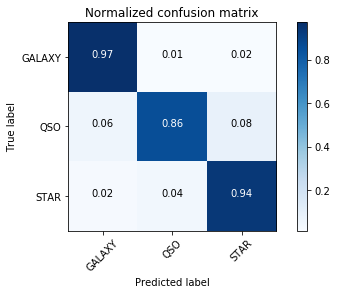

Binary classification results:
Predicted positives: 3819/23188 (16.47%)
logloss = 0.1573
ROC AUC = 0.9782


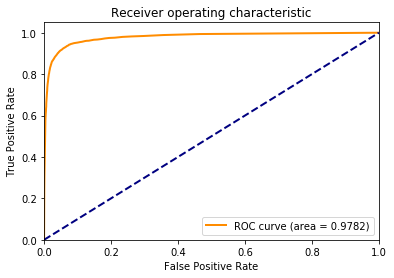

recall = 0.8596
accuracy = 0.9566
precision = 0.8803
f1 = 0.8699


In [16]:
classification_report(preds_1.loc[preds_1['ID'].isin(id_intersection)])

/home/snakoneczny/tools/python3/lib/python3.5/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


Multiclass classification results:
Accuracy = 0.9311
F1 per class = [0.9636 0.8473 0.9217]


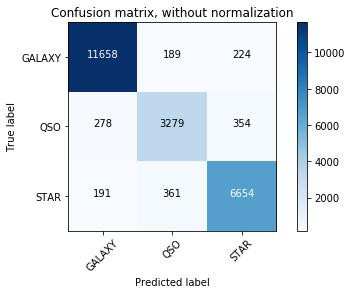

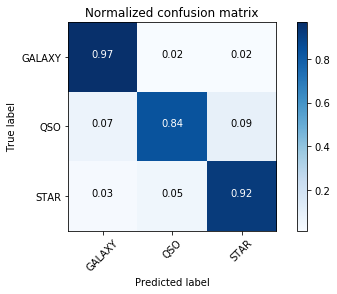

Binary classification results:
Predicted positives: 3829/23188 (16.51%)
logloss = 0.2087
ROC AUC = 0.9679


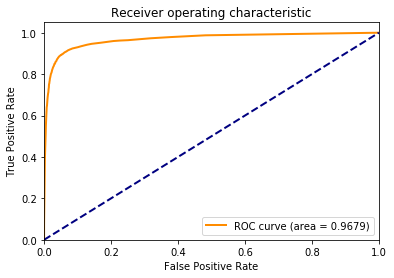

recall = 0.8384
accuracy = 0.9490
precision = 0.8564
f1 = 0.8473


In [17]:
classification_report(preds_2.loc[preds_2['ID'].isin(id_intersection)])

# Astronet
SDSS cleaned, mags+colors+class_star, R cut, all tiles

In [69]:
preds_star = pd.read_csv('experiments/KiDS_DR3_x_SDSS_DR14_star_sdss-clean_astronet_f-all_cut-r__2018-08-03_17:07:55.csv')
# predictions = pd.read_csv('experiments/KiDS_DR3_x_SDSS_DR14_sdss-clean_astronet_f-all_cut-r__2018-08-03_16:41:18.csv')
data_path = '/media/snakoneczny/data/KiDS/KiDS.DR3.x.SDSS.DR14.cols.csv'

Multiclass classification results:
Accuracy = 0.9353
F1 per class = [0.2368 0.9143 0.9532]
Logloss = 0.2187


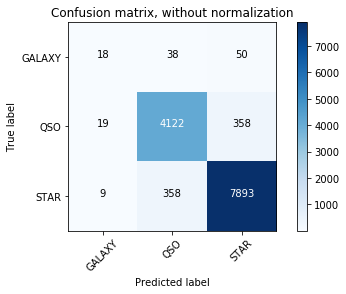

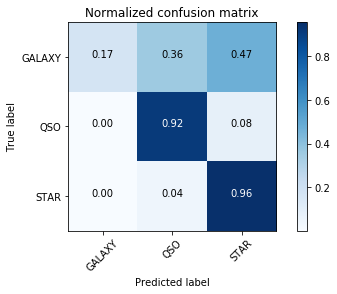

Binary classification results:
Predicted positives: 4518/12865 (35.12%)
logloss = 0.1812
ROC AUC = 0.9799


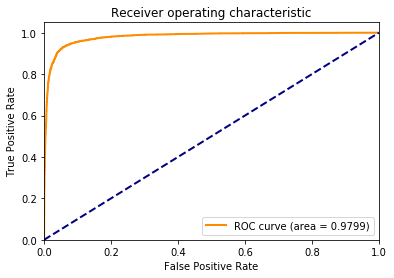

accuracy = 0.9399
f1 = 0.9143
precision = 0.9124
recall = 0.9162


/home/snakoneczny/tools/python3/lib/python3.5/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/home/snakoneczny/tools/python3/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


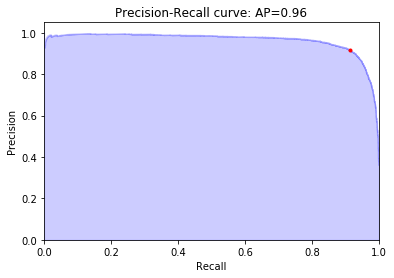

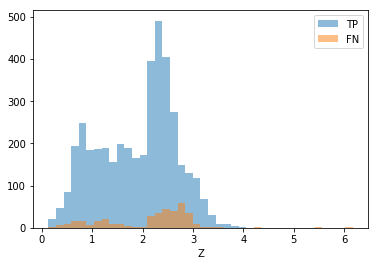

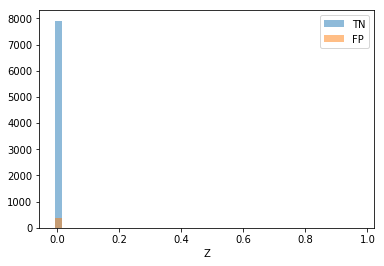

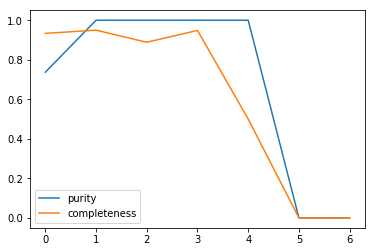

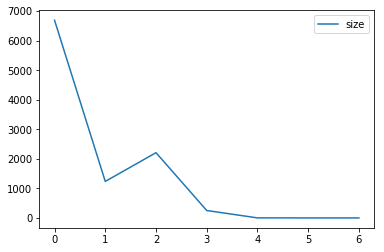

In [71]:
classification_report(preds_star)

In [ ]:
redshift_report(preds_star, data_path)

In [42]:
redshift_report(preds_star)

0.3013878945129163
binned
(-0.00795, 0.492]    8447
(0.492, 0.992]        706
(0.992, 1.492]        624
(1.492, 1.992]        616
(1.992, 2.492]       1394
(2.492, 2.992]        815
(2.992, 3.492]        238
(3.492, 3.992]         20
(3.992, 4.492]          2
(4.492, 4.992]          0
(4.992, 5.492]          0
(5.492, 5.992]          1
(5.992, 6.492]          1
dtype: int64
binned
(-0.00795, 0.492]    0.180922
(0.492, 0.992]       0.657218
(0.992, 1.492]       0.279898
(1.492, 1.992]       0.277766
(1.992, 2.492]       0.515351
(2.492, 2.992]       0.854958
(2.992, 3.492]       0.386559
(3.492, 3.992]       0.825786
(3.992, 4.492]       2.058323
(4.492, 4.992]            NaN
(4.992, 5.492]            NaN
(5.492, 5.992]       5.181839
(5.992, 6.492]       6.311743
Name: residual, dtype: float64


In [74]:
redshift_report(preds_star.loc[preds_star['class_pred'] == 'QSO'])

0.532804223442429
binned
(-0.00402, 0.496]     478
(0.496, 0.996]        654
(0.996, 1.496]        580
(1.496, 1.996]        600
(1.996, 2.496]       1300
(2.496, 2.996]        663
(2.996, 3.496]        222
(3.496, 3.996]         19
(3.996, 4.496]          1
dtype: int64
binned
(-0.00402, 0.496]    1.472156
(0.496, 0.996]       0.672953
(0.996, 1.496]       0.231188
(1.496, 1.996]       0.250664
(1.996, 2.496]       0.423064
(2.496, 2.996]       0.536479
(2.996, 3.496]       0.266810
(3.496, 3.996]       0.686561
(3.996, 4.496]       0.028782
Name: residual, dtype: float64


/home/snakoneczny/workspace/kids_quasars/utils_evaluation.py:135: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  predictions['residual'] = abs(predictions['Z'] - predictions['Z_pred'])
/home/snakoneczny/workspace/kids_quasars/utils_evaluation.py:137: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  predictions['binned'] = pd.cut(predictions['Z'], bins)


# No FLAG_BAND, one model

In [65]:
preds_path = 'outputs/test_preds/KiDS_DR3_x_SDSS_DR14_sdss-clean_rf-clf_f-all_cut-r__2018-10-04_14:52:42.csv'
model_path = 'outputs/test_models/KiDS_DR3_x_SDSS_DR14_sdss-clean_rf-clf_f-all_cut-r__2018-10-04_14:52:42.joblib'

In [66]:
predictions = pd.read_csv(preds_path)
model = joblib.load(model_path) 

Multiclass classification results:
Accuracy = 0.9656
F1 per class = [ 0.9884  0.8867  0.9493]
Logloss = 0.1406


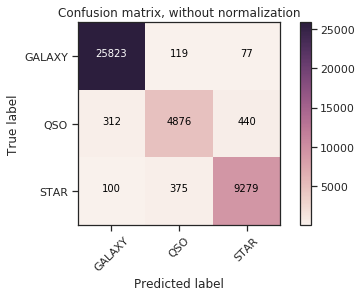

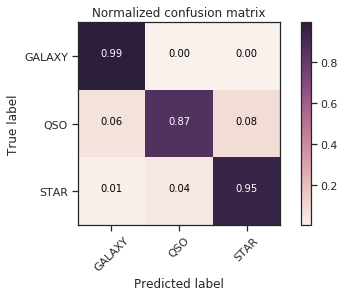

Binary classification results:
Predicted positives: 5370/41401 (12.97%)
logloss = 0.1061
ROC AUC = 0.9853


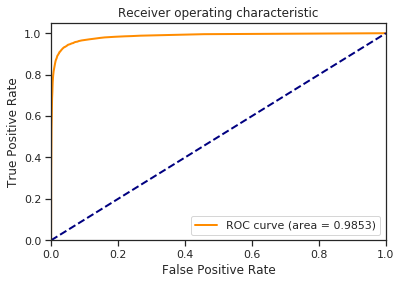

accuracy = 0.9699
f1 = 0.8867
precision = 0.9080
recall = 0.8664


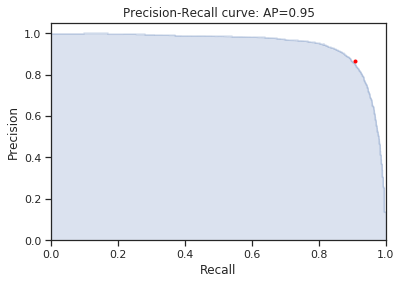

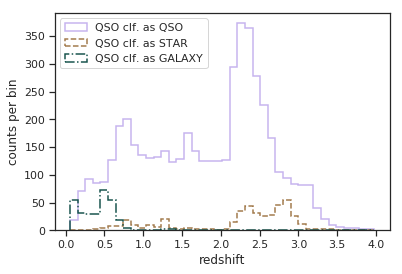

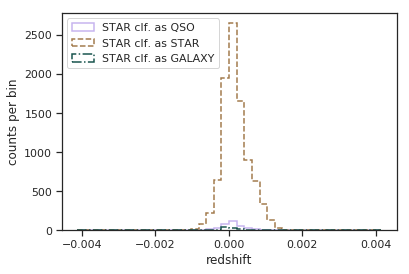

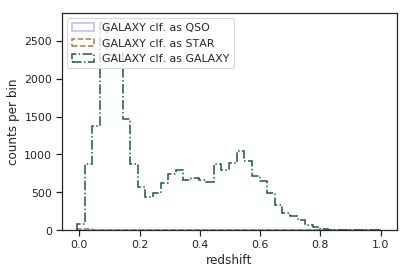

In [67]:
classification_report(predictions, z_max=4)

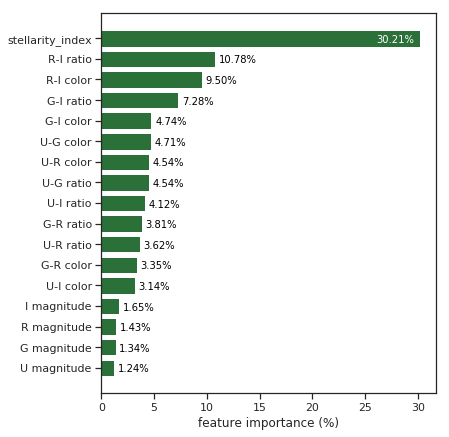

In [60]:
plot_feature_ranking(model, FEATURES['all'])

# No FLAG_BAND, one model, colors and ratios

In [61]:
preds_path = 'outputs/test_preds/KiDS_DR3_x_SDSS_DR14_sdss-clean_rf-clf_f-no-mags_cut-u-g__2018-10-05_15:11:30.csv'
model_path = 'outputs/test_models/KiDS_DR3_x_SDSS_DR14_sdss-clean_rf-clf_f-no-mags_cut-u-g__2018-10-05_15:11:30.joblib'

In [62]:
predictions = pd.read_csv(preds_path)
model = joblib.load(model_path) 

Multiclass classification results:
Accuracy = 0.9634
F1 per class = [ 0.9878  0.8721  0.9457]
Logloss = 0.1543


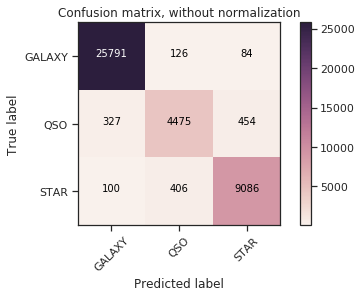

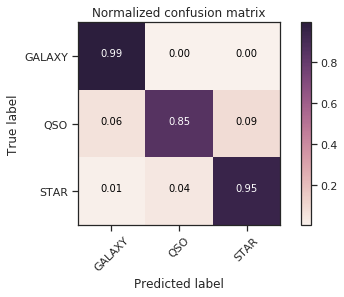

Binary classification results:
Predicted positives: 5007/40849 (12.26%)
logloss = 0.1114
ROC AUC = 0.9831


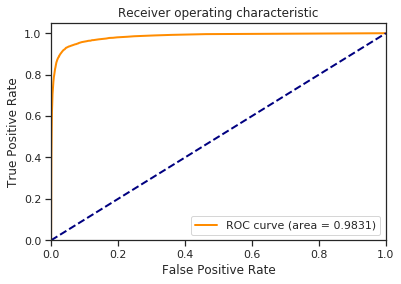

accuracy = 0.9679
f1 = 0.8721
precision = 0.8937
recall = 0.8514


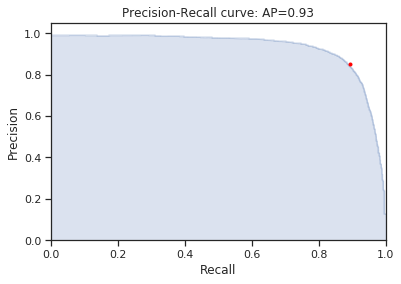

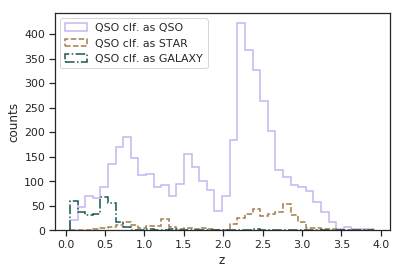

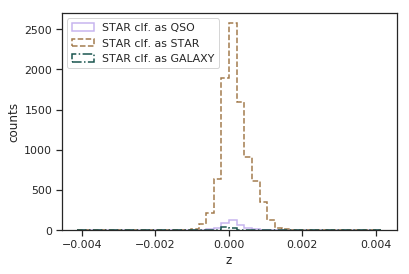

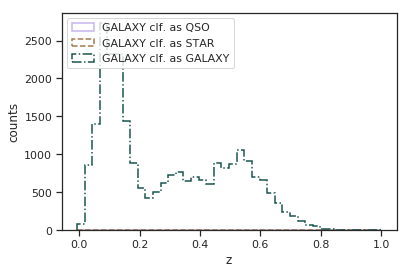

In [63]:
classification_report(predictions, z_max=4)

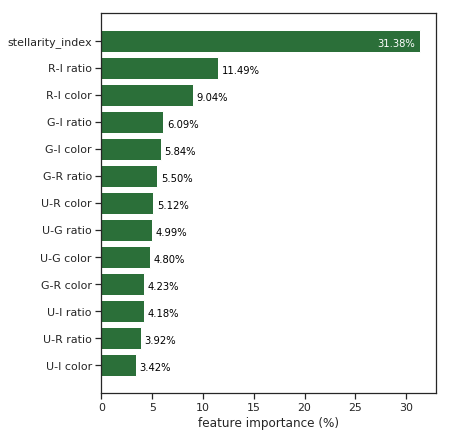

In [64]:
plot_feature_ranking(model, FEATURES['no-mags'])